Use trained phys. GP model to update physical model parameters via least squares fitting to the predictive mean

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
from scipy.optimize import curve_fit
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [4]:
len(pch)

23

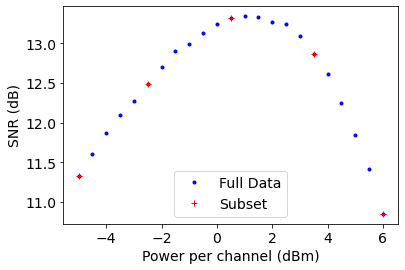

In [5]:
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [6]:
def shift_pch(pch, emp_pk):
    pch_gn = np.linspace(pch[0], pch[-1], 100)
    pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
    return pch_shifted
def gen_phys_targets(model, pch, num_pts_phys):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    snr_phys = (model.predict_snr(pch_gn_shifted)).reshape(-1,1)
    return pch_gn_shifted, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml

**GN Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed

In [7]:
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 5.5, 10, 16.5)
phys_model = GN_model(100, 1550, 1, 0.72, 18, 0.18, 35, 40.2, 50, 4.5, 10, 16, 0.04, 4)
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.174, 35, 40.2, 50, 5.2, 10, 16)

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [8]:
num_pts_phys = 10

In [9]:
pch_gn = np.linspace(pch[0], pch[-1], 100)
emp_pk = 1.2
pch_sub_shifted = shift_pch(pch_sub, emp_pk)
pch_shifted = shift_pch(pch, emp_pk)
pch_gn_shifted, snr_phys = gen_phys_targets(phys_model, pch_shifted, num_pts_phys)
print((emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))]))

0.9777777777777776


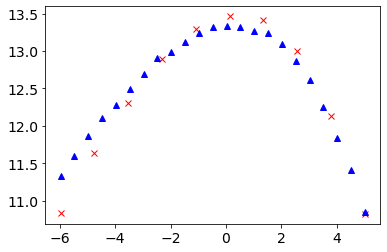

In [10]:
plt.plot(pch_gn_shifted, snr_phys, 'rx')
plt.plot(pch_shifted, snr, 'b^')
plt.show()

In [11]:
pch_test = np.copy(pch_gn_shifted).reshape(-1,1)
snr_phys_test = np.copy(snr_phys).reshape(-1,1)

In [12]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub_shifted, pch_test, snr_sub, snr_phys_test, pch_shifted)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [13]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub_shifted, snr_sub, pch_shifted)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [14]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_standard_gp(pch_shifted, snr, pch_shifted)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

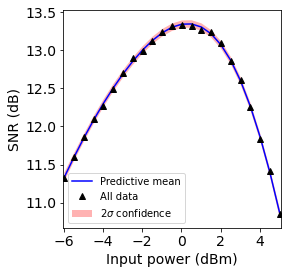

In [15]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_f, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, snr,'k^', label = 'All data')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_f,
                            (mu_sk_n2_f)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc=3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/comp_standard_gp_full.pdf', dpi=200,bbox_inches='tight')
plt.show()

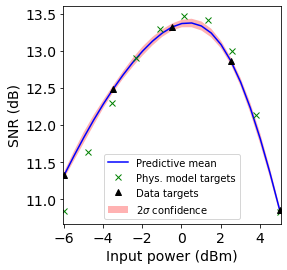

In [16]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub_shifted, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, phys_model_snr_plt, 'k:', label = 'Phys. model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/comp_gn_enhanced_gp.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_gn_enhanced_gp_009.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_gn_enhanced_gp_001.pdf', dpi=200,bbox_inches='tight')
plt.show()

Now use least squares fitting to optimize the inputs to the physical model.  
**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed  
Variable parameters: nonlinearity coefficient, dispersion coefficient, loss, EDFA noise figure, TRx back to back SNR mean

In [17]:
class phys_optimiser:
    def _obj_func(self, p_in, nl_cof, disp_cof, loss, nf, trxbtb):
        model = GN_model(100, 1550, 1, nl_cof, disp_cof, loss, 35, 40.2, 50, nf, 10, trxbtb, 0.04, 4)
        return model.predict_snr(p_in)
#     def _obj_func_amp(self, p_in, disp_cof, loss, trxbtb):
#         model = GN_model(100, 1550, 1, 0.78, disp_cof, loss, 35, 40.2, 50, 4.5, 10, trxbtb, 0.04, 4)
#         return model.predict_snr(p_in)
    def fit(self, p_in, y, init_guess, bounds):
        opt_res = curve_fit(self._obj_func, p_in, y, init_guess, bounds=bounds)
        return opt_res
#     def fit_amp(self, p_in, y, init_guess, bounds):  # fit with amplifier NF fixed (as it is given in spec sheet)
#         opt_res = curve_fit(self._obj_func_amp, p_in, y, init_guess, bounds=bounds)
#         return opt_res

In [18]:
optimiser = phys_optimiser()

In [19]:
y_targets = mu_sk_phys.reshape(len(mu_sk_phys),)

In [20]:
# opt_res = optimiser.fit(pch_shifted, y_targets, init_guess = np.array([0.78, 18., 0.18, 4.3, 16.]),  # v. good
#                         bounds=([0.70, 16., 0.16, 4., 15.], [1.3, 19., 0.2, 6.5, 17.]))
opt_res = optimiser.fit(pch_shifted, y_targets, init_guess = np.array([1., 17., 0.18, 4.3, 16.5]),
                        bounds=([0.72, 15., 0.17, 4.3, 15.], [1.3, 18., 0.2, 4.5, 17.]))
# opt_res = optimiser.fit(pch_shifted, y_targets, init_guess = np.array([17., 0.18, 5.5, 16.5]),
#                          bounds=([15., 0.16, 3., 15.], [19., 0.2, 6.5, 17.]))

In [21]:
nl_cof_opt, disp_cof_opt, loss_opt, nf_opt, trxbtb_opt = opt_res[0]
#disp_cof_opt, loss_opt, nf_opt, trxbtb_opt = opt_res[0]
print("Opt NL cof. = " + '%.3f' %  nl_cof_opt)
print("Opt disp cof. = " + '%.3f' % disp_cof_opt)
print("Opt loss = " + '%.3f' % loss_opt)
print("Opt NF = " + '%.3f' % nf_opt)
print("Opt TRX B2B = " + '%.3f' % trxbtb_opt)

Opt NL cof. = 0.720
Opt disp cof. = 18.000
Opt loss = 0.175
Opt NF = 4.300
Opt TRX B2B = 15.540


In [22]:
nl_cof_opt_sig, disp_cof_opt_sig, loss_opt_sig, nf_opt_sig, trxbtb_opt_sig = np.sqrt(np.diag(opt_res[1]))
np.sqrt(np.diag(opt_res[1]))

array([7.48739049e+04, 4.20749093e+06, 1.02325054e+04, 1.03166734e+06,
       1.15476918e-01])

In [23]:
model_opt = GN_model(100, 1550, 1, nl_cof_opt, disp_cof_opt, loss_opt, 35, 40.2, 50, nf_opt, 10, 15.5, 0.04, 4)
#model_opt = GN_model(100, 1550, 1, 0.76, 18.6, 0.17, 35, 40.2, 50, 4.2, 10, 15.2, 0.04, 4)

Compare results 

In [24]:
phys_snr_opt = model_opt.predict_snr(pch_shifted)  # optimised model
phys_snr = phys_model.predict_snr(pch_shifted)     # initial model

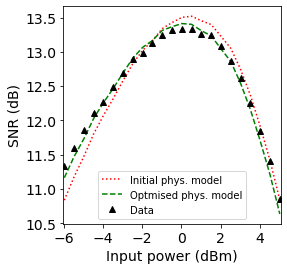

In [25]:
f, ax = plt.subplots()
#ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, phys_snr, 'r:', label = 'Initial phys. model')
ax.plot(pch_shifted, phys_snr_opt, 'g--', label = 'Optmised phys. model')
ax.plot(pch_shifted, snr, 'k^', label = 'Data')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
plt.xticks([-6, -4, -2, 0, 2, 4])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/opt_phys_model_comp_1dbm.pdf', dpi=200,bbox_inches='tight')
plt.show()